<a href="https://colab.research.google.com/github/dipmay-biswas/Soft-Computing-laboratory/blob/master/2021CSB043_assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Assignment 3: Implementation of Artificial Neural Network Perceptron Model for digit and handwritten alphabet recognition

> Name: ***Dipmay Biswas***

> Enrollment ID: ***2021CSB043***

#**Import libraries**

In [167]:
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
import matplotlib.pyplot as plt

## a. ***Digit or not***

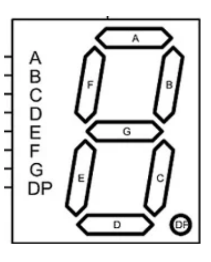

### 1. *Create dataset*

Each representation has 7 bits so -

In [168]:
n = 2 ** 7

In [169]:
X = torch.tensor([list(map(int, np.binary_repr(i, 7))) for i in range(n)], dtype=torch.float)
X.shape

torch.Size([128, 7])

In [170]:
X.shape

torch.Size([128, 7])

In [171]:
valids = torch.tensor([[1, 1, 1, 1, 1, 1, 0],  # 0
                       [0, 1, 1, 0, 0, 0, 0],  # 1
                       [1, 1, 0, 1, 1, 0, 1],  # 2
                       [1, 1, 1, 1, 0, 0, 1],  # 3
                       [0, 1, 1, 0, 0, 1, 1],  # 4
                       [1, 0, 1, 1, 0, 1, 1],  # 5
                       [0, 0, 1, 1, 1, 1, 1],  # 6
                       [1, 1, 1, 0, 0, 0, 0],  # 7
                       [1, 1, 1, 1, 1, 1, 1],  # 8
                       [1, 1, 1, 0, 0, 1, 1]   # 9
                      ], dtype=torch.float)

In [172]:
for i in range(11):
    X = torch.cat((X, valids), axis=0)

In [173]:
X.shape

torch.Size([238, 7])

In [174]:
n = X.shape[0]

In [175]:
y = torch.zeros(n)

for i in range(n):
    for j in range(valids.shape[0]):
        if torch.all(np.equal(X[i], valids[j])):
            y[i] = 1
            break

In [176]:
y.shape

torch.Size([238])

In [177]:
X_train, y_train = X, y

In [178]:
X_train.shape, y_train.shape

(torch.Size([238, 7]), torch.Size([238]))

### 2. *Create neural network architecture with model hyperparameters*

In [179]:
# bit length
in_size = 7
# output should be 1 or 0
out_size = 1

In [180]:
# a subclass from nn.Module to hold weights in b/n different layers
class NNet_digi(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(in_size, 4),         # b/n input layer and 1st hidden layer
            nn.Sigmoid(),                   # activation
            nn.Linear(4, 10),              # b/n 1st and 2nd hidden layers
            nn.Sigmoid(),                   # activation
            nn.Linear(10, out_size),        # b/n 2nd hidden layer and output layer
        )

    def forward(self, x):
        logits = self.linear_stack(x).reshape((-1,))
        return logits

In [181]:
digi = NNet_digi()

### 3. *Hyperparameters external to model*

In [182]:
# define learning rate
lr = 0.1

In [183]:
loss_fn = nn.MSELoss()
optim = torch.optim.SGD(digi.parameters(), lr=lr)

In [184]:
# define number of folds for cross-validation
n_folds = 8

In [185]:
# number of batches
n_batches = 2

### 4. *Train, validate*

In [186]:
train_losses = []
acc_scores = []
f1_scores = []
precision_scores = []
recall_scores = []
iters = []
itr = 0

In [187]:
seeds = [i for i in range(n_batches)]

In [188]:
for i in range(n_batches):
    kf_instance = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seeds[i])
    for train_idx, eval_idx in kf_instance.split(X_train, y_train):
        # train
        digi.train()
        h = digi.forward(X_train[train_idx])
        loss = loss_fn(y_train[train_idx], h)

        # backpropagate
        loss.backward()
        optim.step()
        optim.zero_grad()

        # validate
        digi.eval()
        with torch.no_grad():
            y_b = digi.forward(X_train[eval_idx])

        # calculate losses
        train_losses.append(loss.item())
        acc_scores.append(accuracy_score(y_train[eval_idx], y_b.round()))
        f1_scores.append(f1_score(y_train[eval_idx], y_b.round(), zero_division=0))
        precision_scores.append(precision_score(y_train[eval_idx], y_b.round(), zero_division=0))
        recall_scores.append(recall_score(y_train[eval_idx], y_b.round(), zero_division=0))

        iters.append(itr)
        itr += 1

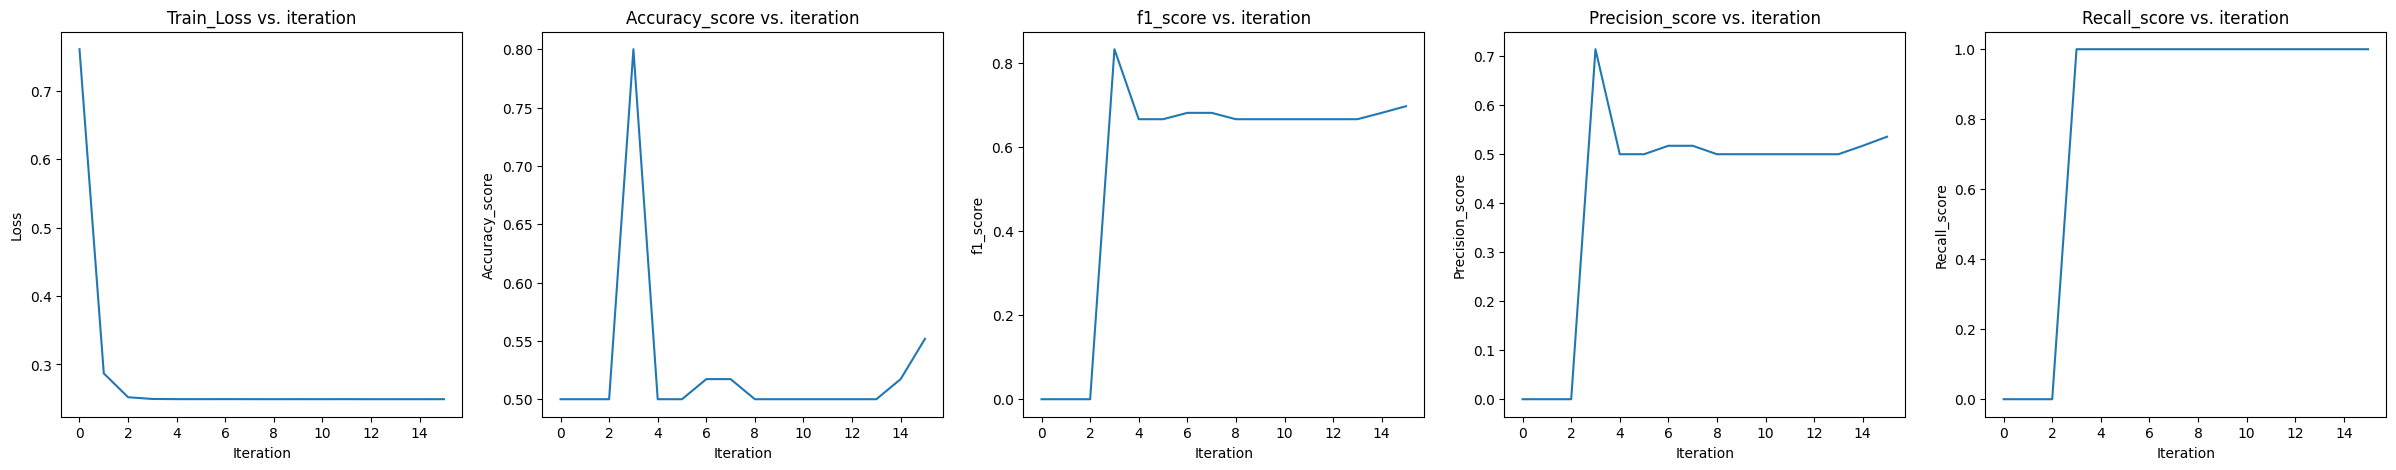

In [189]:
fig, axs = plt.subplots(1, 5, figsize=(30, 5), sharex=True)

axs[0].plot(iters, train_losses)
axs[0].set_title('Train_Loss vs. iteration')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Loss')
axs[1].plot(iters, acc_scores)
axs[1].set_title('Accuracy_score vs. iteration')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Accuracy_score')
axs[2].plot(iters, f1_scores)
axs[2].set_title('f1_score vs. iteration')
axs[2].set_xlabel('Iteration')
axs[2].set_ylabel('f1_score')
axs[3].plot(iters, precision_scores)
axs[3].set_title('Precision_score vs. iteration')
axs[3].set_xlabel('Iteration')
axs[3].set_ylabel('Precision_score')
axs[4].plot(iters, recall_scores)
axs[4].set_title('Recall_score vs. iteration')
axs[4].set_xlabel('Iteration')
axs[4].set_ylabel('Recall_score');

## b. ***Alphabet or not***

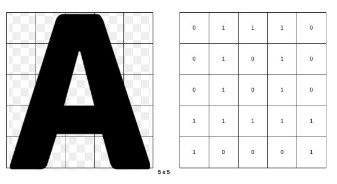

### 1. *Create database*

#### Create the alphabet

In [190]:
a = [[[0, 0, 1, 0, 0],
      [0, 1, 0, 1, 0],
      [1, 1, 1, 1, 1],
      [1, 0, 0, 0, 1],
      [1, 0, 0, 0, 1]],

     [[0, 1, 1, 1, 0],
      [0, 1, 0, 1, 0],
      [0, 1, 0, 1, 0],
      [1, 1, 1, 1, 1],
      [1, 0, 0, 0, 1]]]

b = [[[1, 1, 1, 1, 0],
      [1, 0, 0, 0, 1],
      [1, 1, 1, 1, 1],
      [1, 0, 0, 0, 1],
      [1, 1, 1, 1, 0]],
     ]

c = [[[0, 1, 1, 1, 1],
      [1, 0, 0, 0, 0],
      [1, 0, 0, 0, 0],
      [1, 0, 0, 0, 0],
      [0, 1, 1, 1, 1]],

     [[1, 1, 1, 1, 1],
      [1, 0, 0, 0, 0],
      [1, 0, 0, 0, 0],
      [1, 0, 0, 0, 0],
      [1, 1, 1, 1, 1]]]

d = [[[1, 1, 1, 1, 0],
      [1, 0, 0, 0, 1],
      [1, 0, 0, 0, 1],
      [1, 0, 0, 0, 1],
      [1, 1, 1, 1, 0]],

     [[1, 1, 1, 0, 0],
      [1, 0, 0, 1, 0],
      [1, 0, 0, 0, 1],
      [1, 0, 0, 1, 0],
      [1, 1, 1, 0, 0]],

     [[1, 1, 1, 0, 0],
      [1, 0, 0, 1, 0],
      [1, 0, 0, 1, 0],
      [1, 0, 0, 1, 0],
      [1, 1, 1, 0, 0]]]

e = [[[1, 1, 1, 1, 1],
      [1, 0, 0, 0, 0],
      [1, 1, 1, 1, 1],
      [1, 0, 0, 0, 0],
      [1, 1, 1, 1, 1]]]

f = [[[1, 1, 1, 1, 1],
      [1, 0, 0, 0, 0],
      [1, 1, 1, 1, 1],
      [1, 0, 0, 0, 0],
      [1, 0, 0, 0, 0]]]

g = [[[1, 1, 1, 1, 1],
      [1, 0, 0, 0, 0],
      [1, 0, 1, 1, 1],
      [1, 0, 0, 0, 1],
      [1, 1, 1, 1, 1]],

     [[1, 1, 1, 1, 1],
      [1, 0, 0, 0, 0],
      [1, 0, 1, 1, 1],
      [1, 0, 0, 1, 1],
      [1, 1, 1, 1, 1]],

     [[0, 1, 1, 1, 1],
      [1, 0, 0, 0, 0],
      [1, 0, 1, 1, 1],
      [1, 0, 0, 0, 1],
      [0, 1, 1, 1, 1]]]

h = [[[1, 0, 0, 0, 1],
      [1, 0, 0, 0, 1],
      [1, 1, 1, 1, 1],
      [1, 0, 0, 0, 1],
      [1, 0, 0, 0, 1]]]

i = [[[0, 0, 1, 0, 0],
      [0, 0, 1, 0, 0],
      [0, 0, 1, 0, 0],
      [0, 0, 1, 0, 0],
      [0, 0, 1, 0, 0]],

     [[1, 1, 1, 1, 1],
      [0, 0, 1, 0, 0],
      [0, 0, 1, 0, 0],
      [0, 0, 1, 0, 0],
      [1, 1, 1, 1, 1]],

     [[0, 0, 1, 1, 0],
      [0, 0, 1, 1, 0],
      [0, 0, 1, 1, 0],
      [0, 0, 1, 1, 0],
      [0, 0, 1, 1, 0]],

     [[0, 1, 1, 1, 1],
      [0, 0, 1, 1, 0],
      [0, 0, 1, 1, 0],
      [0, 0, 1, 1, 0],
      [0, 1, 1, 1, 1]],

     [[0, 1, 1, 0, 0],
      [0, 1, 1, 0, 0],
      [0, 1, 1, 0, 0],
      [0, 1, 1, 0, 0],
      [0, 1, 1, 0, 0]],

     [[1, 1, 1, 1, 0],
      [0, 1, 1, 0, 0],
      [0, 1, 1, 0, 0],
      [0, 1, 1, 0, 0],
      [1, 1, 1, 1, 0]],

     [[1, 1, 1, 1, 0],
      [0, 1, 1, 1, 0],
      [0, 1, 1, 1, 0],
      [0, 1, 1, 1, 0],
      [1, 1, 1, 1, 0]],

     [[1, 1, 1, 1, 1],
      [1, 1, 1, 1, 1],
      [0, 0, 1, 0, 0],
      [1, 1, 1, 1, 1],
      [1, 1, 1, 1, 1]]]

j = [[[1, 1, 1, 0, 0],
      [0, 0, 1, 0, 0],
      [0, 0, 1, 0, 0],
      [1, 0, 1, 0, 0],
      [0, 1, 0, 0, 0]],

     [[1, 1, 1, 1, 0],
      [0, 0, 1, 1, 0],
      [0, 0, 1, 1, 0],
      [1, 0, 1, 1, 0],
      [0, 1, 1, 0, 0]],

     [[1, 1, 1, 1, 0],
      [0, 0, 0, 1, 0],
      [0, 0, 0, 1, 0],
      [1, 0, 0, 1, 0],
      [0, 1, 1, 0, 0]],

     [[1, 1, 1, 1, 1],
      [0, 0, 0, 1, 1],
      [0, 0, 0, 1, 1],
      [1, 1, 0, 1, 1],
      [0, 1, 1, 1, 0]]]

k = [[[1, 1, 0, 1, 1],
      [1, 1, 0, 1, 0],
      [1, 1, 1, 0, 0],
      [1, 1, 0, 1, 0],
      [1, 1, 0, 1, 1]],

     [[1, 0, 0, 0, 1],
      [1, 0, 0, 1, 0],
      [1, 1, 1, 0, 0],
      [1, 0, 0, 1, 0],
      [1, 0, 0, 0, 1]]]

l = [[[1, 0, 0, 0, 0],
      [1, 0, 0, 0, 0],
      [1, 0, 0, 0, 0],
      [1, 0, 0, 0, 0],
      [1, 1, 1, 1, 1]],

     [[1, 0, 0, 0, 0],
      [1, 1, 0, 0, 0],
      [1, 1, 0, 0, 0],
      [1, 1, 1, 1, 1],
      [1, 1, 1, 1, 1]]]

m = [[[1, 0, 0, 0, 1],
      [1, 1, 0, 1, 1],
      [1, 0, 1, 0, 1],
      [1, 0, 0, 0, 1],
      [1, 0, 0, 0, 1]],

     [[1, 1, 0, 1, 1],
      [1, 1, 0, 1, 1],
      [1, 1, 1, 1, 1],
      [1, 1, 0, 1, 1],
      [1, 1, 0, 1, 1]]]

n = [[[1, 0, 0, 0, 1],
      [1, 1, 0, 0, 1],
      [1, 0, 1, 0, 1],
      [1, 0, 0, 1, 1],
      [1, 0, 0, 0, 1]],

     [[1, 0, 0, 1, 1],
      [1, 1, 0, 1, 1],
      [1, 1, 1, 1, 1],
      [1, 1, 0, 1, 1],
      [1, 1, 0, 0, 1]]]

o = [[[0, 1, 1, 1, 0],
      [1, 0, 0, 0, 1],
      [1, 0, 0, 0, 1],
      [1, 0, 0, 0, 1],
      [0, 1, 1, 1, 0]],

     [[0, 1, 1, 1, 0],
      [1, 1, 1, 1, 1],
      [1, 1, 0, 1, 1],
      [1, 1, 1, 1, 1],
      [0, 1, 1, 1, 0]]]

p = [[[1, 1, 1, 0, 0],
      [1, 0, 0, 1, 0],
      [1, 1, 1, 0, 0],
      [1, 0, 0, 0, 0],
      [1, 0, 0, 0, 0]],

     [[1, 1, 1, 1, 1],
      [1, 0, 0, 0, 1],
      [1, 1, 1, 1, 1],
      [1, 0, 0, 0, 0],
      [1, 0, 0, 0, 0]],

     [[1, 1, 1, 1, 1],
      [1, 1, 0, 0, 1],
      [1, 1, 1, 1, 1],
      [1, 1, 0, 0, 0],
      [1, 1, 0, 0, 0]],

     [[1, 1, 1, 0, 0],
      [1, 1, 0, 1, 0],
      [1, 1, 1, 0, 0],
      [1, 1, 0, 0, 0],
      [1, 1, 0, 0, 0]]]

q = [[[0, 1, 1, 1, 0],
      [1, 0, 0, 0, 1],
      [1, 0, 1, 0, 1],
      [0, 1, 1, 1, 0],
      [0, 0, 0, 1, 1]]]

r = [[[1, 1, 1, 1, 0],
      [1, 0, 0, 0, 1],
      [1, 1, 1, 1, 0],
      [1, 0, 0, 1, 0],
      [1, 0, 0, 0, 1]],

     [[1, 1, 1, 1, 0],
      [1, 1, 0, 0, 1],
      [1, 1, 1, 1, 0],
      [1, 1, 0, 1, 0],
      [1, 1, 0, 0, 1]]]

s = [[[0, 1, 1, 1, 1],
      [1, 0, 0, 0, 0],
      [0, 1, 1, 1, 0],
      [0, 0, 0, 0, 1],
      [1, 1, 1, 1, 0]],

     [[1, 1, 1, 1, 1],
      [1, 0, 0, 0, 0],
      [0, 1, 1, 1, 0],
      [0, 0, 0, 0, 1],
      [1, 1, 1, 1, 1]]]

t = [[[1, 1, 1, 1, 1],
      [0, 0, 1, 0, 0],
      [0, 0, 1, 0, 0],
      [0, 0, 1, 0, 0],
      [0, 0, 1, 0, 0]],

     [[1, 1, 1, 1, 1],
      [1, 1, 1, 1, 1],
      [0, 0, 1, 0, 0],
      [0, 0, 1, 0, 0],
      [0, 0, 1, 0, 0]]]

u = [[[1, 0, 0, 0, 1],
      [1, 0, 0, 0, 1],
      [1, 0, 0, 0, 1],
      [1, 0, 0, 0, 1],
      [0, 1, 1, 1, 0]],

     [[1, 1, 0, 1, 1],
      [1, 1, 0, 1, 1],
      [1, 1, 0, 1, 1],
      [1, 1, 0, 1, 1],
      [0, 1, 1, 1, 0]]]

v = [[[1, 0, 0, 0, 1],
      [1, 0, 0, 0, 1],
      [1, 0, 0, 0, 1],
      [0, 1, 0, 1, 0],
      [0, 0, 1, 0, 0]],

     [[1, 1, 0, 1, 1],
      [1, 1, 0, 1, 1],
      [1, 1, 0, 1, 1],
      [0, 1, 1, 1, 0],
      [0, 0, 1, 0, 0]]]

w = [[[1, 0, 0, 0, 1],
      [1, 0, 0, 0, 1],
      [1, 0, 1, 0, 1],
      [1, 0, 1, 0, 1],
      [0, 1, 0, 1, 0]],

     [[1, 0, 0, 0, 1],
      [1, 0, 0, 0, 1],
      [1, 0, 1, 0, 1],
      [1, 1, 1, 1, 1],
      [0, 1, 0, 1, 0]]]

x = [[[1, 0, 0, 0, 1],
      [1, 0, 0, 0, 1],
      [0, 1, 1, 1, 0],
      [1, 0, 0, 0, 1],
      [1, 0, 0, 0, 1]],

     [[1, 0, 0, 0, 1],
      [1, 1, 0, 1, 0],
      [0, 0, 1, 0, 0],
      [0, 1, 0, 1, 0],
      [1, 0, 0, 0, 1]]]

y = [[[1, 0, 0, 0, 1],
      [0, 1, 0, 1, 0],
      [0, 0, 1, 0, 0],
      [0, 0, 1, 0, 0],
      [0, 0, 1, 0, 0]],

     [[1, 1, 0, 1, 1],
      [1, 1, 0, 1, 1],
      [0, 1, 1, 1, 0],
      [0, 0, 1, 0, 0],
      [0, 0, 1, 0, 0]]]

z = [[[1, 1, 1, 1, 1],
      [0, 0, 0, 1, 0],
      [0, 0, 1, 0, 0],
      [0, 1, 0, 0, 0],
      [1, 1, 1, 1, 1]],

     [[1, 1, 1, 1, 1],
      [0, 0, 0, 1, 1],
      [0, 0, 1, 0, 0],
      [1, 1, 0, 0, 0],
      [1, 1, 1, 1, 1]]]

In [191]:
alp = torch.tensor([_ for _ in a])

In [192]:
alp

tensor([[[0, 0, 1, 0, 0],
         [0, 1, 0, 1, 0],
         [1, 1, 1, 1, 1],
         [1, 0, 0, 0, 1],
         [1, 0, 0, 0, 1]],

        [[0, 1, 1, 1, 0],
         [0, 1, 0, 1, 0],
         [0, 1, 0, 1, 0],
         [1, 1, 1, 1, 1],
         [1, 0, 0, 0, 1]]])

In [193]:
for el in [b, c, d, e, f, g, h, i, j, k, l, m, n, o, p, q, r, s, t, u, v, w, x, y, z]:
    alp = torch.cat((alp, torch.tensor(el)), axis=0)

In [194]:
alp.shape

torch.Size([59, 5, 5])

#### Create possible 5\*5 matrices

In [195]:
# it takes a lot of time and memory
# to generate all possible (2**25) patterns
n = 2 ** 10

In [196]:
X = torch.randint(2, (n, 5, 5), dtype=torch.float)

In [197]:
X.shape

torch.Size([1024, 5, 5])

We have total $2^{25}$ patterns, out of which only $59$ patterns are taken in alphabet.  
  
Then, possibility for letters to occur in `X`, $\frac{59}{2^{25}} \times 2^{10} = \frac{59}{32768} << 1$  
That is, `X` will hardly contain **1 element that also belongs to** `alp`.  
  
In that case, we may go ahead, and append `X` $\lfloor\frac{1024}{59}\rfloor = 17$ times to `alp`.

In [198]:
for _ in range(17):
    X = torch.cat((X, alp), axis=0)

In [199]:
X.shape

torch.Size([2027, 5, 5])

In [200]:
n = X.shape[0]

In [201]:
y = torch.zeros(n)

for i in range(n):
    for j in range(alp.shape[0]):
        if torch.all(np.equal(X[i], alp[j])):
            y[i] = 1
            break

In [202]:
y.shape

torch.Size([2027])

### 2. *Create neural network*

In [203]:
# total size after flattening
in_size = 25
# output should be 1 or 0
out_size = 1

In [204]:
# a subclass from nn.Module to hold weights in b/n different layers
class NNet_alpha(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_size, 1024),         # b/n input layer and 1st hidden layer
            nn.Sigmoid(),                   # activation
            nn.Dropout(0.5),
            nn.Linear(1024, 128),              # b/n 1st and 2nd hidden layers
            nn.Dropout(0.2),
            nn.Sigmoid(),                   # activation
            nn.Linear(128, out_size),        # b/n 2nd hidden layer and output layer
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_stack(x).reshape((-1,))
        return logits

In [205]:
alpha = NNet_alpha()

### 3. *Hyperparameters external to network model*

In [206]:
lr = 2e-2
loss_fn = nn.MSELoss()

In [207]:
optim = torch.optim.SGD(alpha.parameters(), lr=lr)

In [208]:
n_folds = 8

In [209]:
n_batches = 6

### 4. *Train, validate*

In [210]:
train_losses = []
acc_scores = []
f1_scores = []
precision_scores = []
recall_scores = []
iters = []
itr = 0

In [211]:
seeds = [i for i in range(n_batches)]

In [212]:
for i in range(n_batches):
    kf_instance = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seeds[i])
    for train_idx, eval_idx in kf_instance.split(X, y):
        # train
        alpha.train()
        h = alpha.forward(X[train_idx])
        loss = loss_fn(y[train_idx], h)

        # backpropagate
        loss.backward()
        optim.step()
        optim.zero_grad()

        # validate
        alpha.eval()
        with torch.no_grad():
            y_b = alpha.forward(X[eval_idx])

        # calculate losses
        train_losses.append(loss.item())
        acc_scores.append(accuracy_score(y[eval_idx], y_b.round()))
        f1_scores.append(f1_score(y[eval_idx], y_b.round(), zero_division=0))
        precision_scores.append(precision_score(y[eval_idx], y_b.round(), zero_division=0))
        recall_scores.append(recall_score(y[eval_idx], y_b.round(), zero_division=0))

        iters.append(itr)
        itr += 1

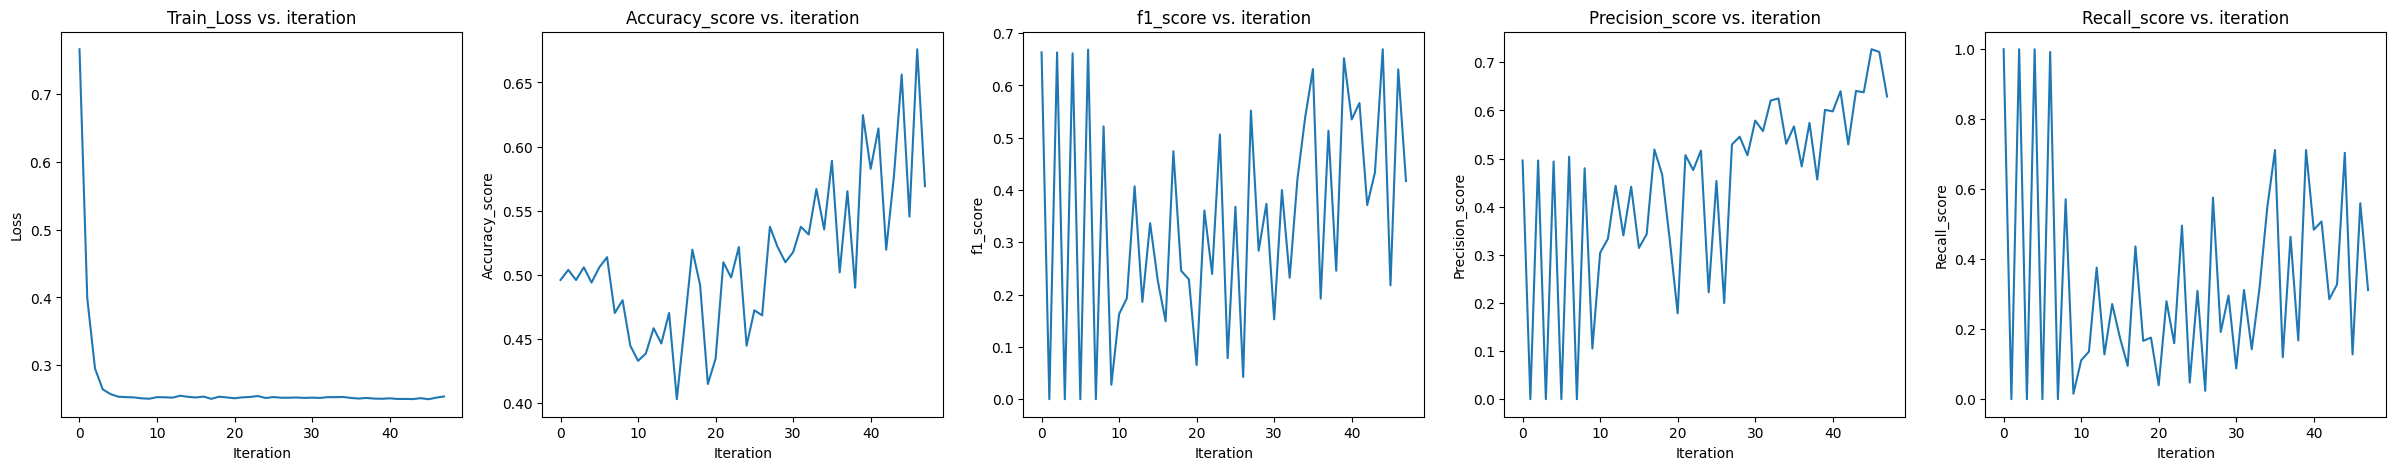

In [213]:
fig, axs = plt.subplots(1, 5, figsize=(30, 5), sharex=True)

axs[0].plot(iters, train_losses)
axs[0].set_title('Train_Loss vs. iteration')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Loss')
axs[1].plot(iters, acc_scores)
axs[1].set_title('Accuracy_score vs. iteration')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Accuracy_score')
axs[2].plot(iters, f1_scores)
axs[2].set_title('f1_score vs. iteration')
axs[2].set_xlabel('Iteration')
axs[2].set_ylabel('f1_score')
axs[3].plot(iters, precision_scores)
axs[3].set_title('Precision_score vs. iteration')
axs[3].set_xlabel('Iteration')
axs[3].set_ylabel('Precision_score')
axs[4].plot(iters, recall_scores)
axs[4].set_title('Recall_score vs. iteration')
axs[4].set_xlabel('Iteration')
axs[4].set_ylabel('Recall_score');

#*Thank you!*